## ALSO FEATURE ENGINEERING AND PREDICTIONS BUT NOW DOING IT BY PREDICTING NET_WEIGHT BY ROW AND THEN DOING THE CUMULATIVE SUM AFTER

In [397]:
# ============================================================
# 0. Imports & Setup
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay

In [398]:
prediction_mapping = pd.read_csv("C:\\Users\\bupat\\OneDrive\\Documentos\\NTNU\\modern_ml_in_practice\\append_consulting_project\\data\\prediction_mapping.csv")
#df_rec_purchase = pd.read_csv("C:\\Users\\bupat\\OneDrive\\Documentos\\NTNU\\modern_ml_in_practice\\append_consulting_project\\data\\kernel\\cleaned_receivals.csv")
df_rec_purchase = pd.read_csv("C:\\Users\\bupat\\OneDrive\\Documentos\\NTNU\\modern_ml_in_practice\\append_consulting_project\\data\\kernel\\copy_purchase_receivals.csv")

print("Files loaded successfully!")
print("\n--- prediction_mapping ---")
print(prediction_mapping.head())

print("\n--- df_rec_purchase ---")
print(df_rec_purchase.head())

Files loaded successfully!

--- prediction_mapping ---
   ID  rm_id forecast_start_date forecast_end_date
0   1    365          2025-01-01        2025-01-02
1   2    365          2025-01-01        2025-01-03
2   3    365          2025-01-01        2025-01-04
3   4    365          2025-01-01        2025-01-05
4   5    365          2025-01-01        2025-01-06

--- df_rec_purchase ---
   Unnamed: 0  rm_id  product_id  receival_item_no date_arrival  \
0           0  342.0    91900170                 1   2004-06-23   
1           1  343.0    91900143                 1   2005-03-29   
2           2  345.0    91900143                 1   2004-09-01   
3           3  346.0    91900146                 3   2004-06-24   
4           4  346.0    91900146                 1   2004-06-30   

   receival_status  net_weight  supplier_id  day_of_year  month  year  \
0                0     24940.0        52433          175      6  2004   
1                0     21760.0        54748           88      3  

## DROP UNIT_STATUS, STATUS_ID AND RECEIVAL_STATUS AS THESE ARE MAINLY JUST ONE VALUE AND HAVE VERY LITTLE CORRELATION TO TARGET VALUE

In [399]:
# DROP UNIT_STATUS, STATUS_ID AND RECEIVAL_STATUS AS THESE ARE MAINLY JUST ONE VALUE AND HAVE VERY LITTLE CORRELATION TO TARGET VALUE
df_rec_purchase = df_rec_purchase.drop(columns=[#'unit_status', 
                                                'status_id', 
                                                'receival_status']) 

## GETTING JUST ONE ROW PER DAY PER RM_ID AND DATE. SO SUM NET_WEIGHT, TARE_WEIGHT, GROSS_WEIGHT, QUANTITY, IMPURITY_DEDUCTION_WEIGHT. THEN DO AVERAGE OF VEHICLE START AND END_WEIGHT THAT DATE, NOW WHAT TO DO FOR CATEGORICAL FEATURES SUPPLIER_ID, VEHICLE_NO, PRODUCT_VERSION, RECEIVAL_ITEM_NO AND PRODUCT_ID? ALSO WHEN JUST HAVING THIS 1 ROW, KEEP RM_ID, YEAR, DAY_OF_YEAR, MONTH, DATE_ARRIVAL AND PURCHASE_PROB FEATURES

In [400]:
# Define aggregation dictionary
agg_dict = {
    # Summed numeric totals
    'net_weight': 'sum',
    #'tare_weight': 'sum',
    #'gross_weight': 'sum',
    'quantity': 'sum',
    #'impurity_deduction_weight': 'sum',

    # Averages
    #'vehicle_start_weight': 'mean',
    #'vehicle_end_weight': 'mean',
    'product_version': 'mean',
    'receival_item_no': 'mean',

    # Categorical / ID handling
    'product_id': 'first',
    'supplier_id': 'nunique',
    #'vehicle_no': 'nunique',

    # Keep this as reference (likely constant)
    #'purchase_prob': 'first'
}

# Perform daily aggregation per rm_id
df_daily = (
    df_rec_purchase.groupby(['rm_id', 'year', 'day_of_year', 'month', 'date_arrival'], as_index=False)
      .agg(agg_dict)
)

df_rec_purchase = df_daily.copy()

print("✅ Aggregated dataset shape:", df_daily.shape)
print(df_daily.head())


✅ Aggregated dataset shape: (40705, 11)
   rm_id  year  day_of_year  month date_arrival  net_weight   quantity  \
0  342.0  2004          175      6   2004-06-23     24940.0    52000.0   
1  343.0  2005           88      3   2005-03-29     21760.0  4530000.0   
2  345.0  2004          245      9   2004-09-01     22780.0  6575000.0   
3  346.0  2004          176      6   2004-06-24       820.0   335550.0   
4  346.0  2004          182      6   2004-06-30     21260.0   600000.0   

   product_version  receival_item_no  product_id  supplier_id  
0              1.0               1.0    91900170            1  
1              1.0               1.0    91900143            1  
2              1.0               1.0    91900143            1  
3              1.0               3.0    91900146            1  
4              1.0               1.0    91900146            1  


### NOW FILL THE WHOLE DATASET WITH ALL POSSIBLE DATES FROM MIN DATE TO MAX DATE, FOR ALL RM_IDS IN THE DATASET. TAKE INTO ACCOUNT THAT SOME OF THE DATES OF COURSE ALREADY EXIST SO DO NOT FILL THOSE, AND PUT JUST THE RM_ID, DAY_OF_YEAR, MONTH AND YEAR AS VALUES AND THE REST OF THE FEATURES TO ZERO, EVEN NET_WEIGHT.

In [401]:
import pandas as pd
import numpy as np

# ============================================================
# 0️⃣ Ensure date_arrival is datetime
# ============================================================
df_rec_purchase['date_arrival'] = pd.to_datetime(df_rec_purchase['date_arrival'], errors='coerce')

# ============================================================
# 1️⃣ Prepare date range and RM_ID list
# ============================================================
min_date = df_rec_purchase['date_arrival'].min()
max_date = df_rec_purchase['date_arrival'].max()

print(f"📅 Expanding dates from {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
all_rm_ids = df_rec_purchase['rm_id'].unique()

# ============================================================
# 2️⃣ Create full RM_ID × date grid
# ============================================================
full_index = pd.MultiIndex.from_product(
    [all_rm_ids, all_dates],
    names=['rm_id', 'date_arrival']
)
full_df = pd.DataFrame(index=full_index).reset_index()

# ============================================================
# 3️⃣ Merge original dataset onto full grid
# ============================================================
df_expanded = full_df.merge(df_rec_purchase, on=['rm_id', 'date_arrival'], how='left')

# ============================================================
# 4️⃣ Fill derived date parts
# ============================================================
df_expanded['year'] = df_expanded['date_arrival'].dt.year
df_expanded['month'] = df_expanded['date_arrival'].dt.month
df_expanded['day_of_year'] = df_expanded['date_arrival'].dt.dayofyear

# ============================================================
# 5️⃣ Fill missing numeric features with 0
# ============================================================
numeric_cols = df_rec_purchase.select_dtypes(include=[np.number]).columns.tolist()
df_expanded[numeric_cols] = df_expanded[numeric_cols].fillna(0)

# ============================================================
# 6️⃣ Sort and finalize
# ============================================================
df_expanded = df_expanded.sort_values(['rm_id', 'date_arrival']).reset_index(drop=True)
df_rec_purchase = df_expanded.copy()

print("✅ Expanded dataset created successfully!")
print(f"Shape: {df_rec_purchase.shape}")
print(df_rec_purchase.head())


📅 Expanding dates from 2004-06-15 to 2024-12-19
✅ Expanded dataset created successfully!
Shape: (1423670, 11)
   rm_id date_arrival  year  day_of_year  month  net_weight  quantity  \
0  342.0   2004-06-15  2004          167      6         0.0       0.0   
1  342.0   2004-06-16  2004          168      6         0.0       0.0   
2  342.0   2004-06-17  2004          169      6         0.0       0.0   
3  342.0   2004-06-18  2004          170      6         0.0       0.0   
4  342.0   2004-06-19  2004          171      6         0.0       0.0   

   product_version  receival_item_no  product_id  supplier_id  
0              0.0               0.0         0.0          0.0  
1              0.0               0.0         0.0          0.0  
2              0.0               0.0         0.0          0.0  
3              0.0               0.0         0.0          0.0  
4              0.0               0.0         0.0          0.0  


## CREATE CUM_WEIGHT_YEAR

In [402]:
# create feature cum_weight_per_year for each of the rm_id per year until that day_of_year, counting the net_weight of that day_of_year
df_rec_purchase['cum_weight_per_year'] = df_rec_purchase.groupby(['rm_id', 'year'])['net_weight'].cumsum()

## BOX-PLOT

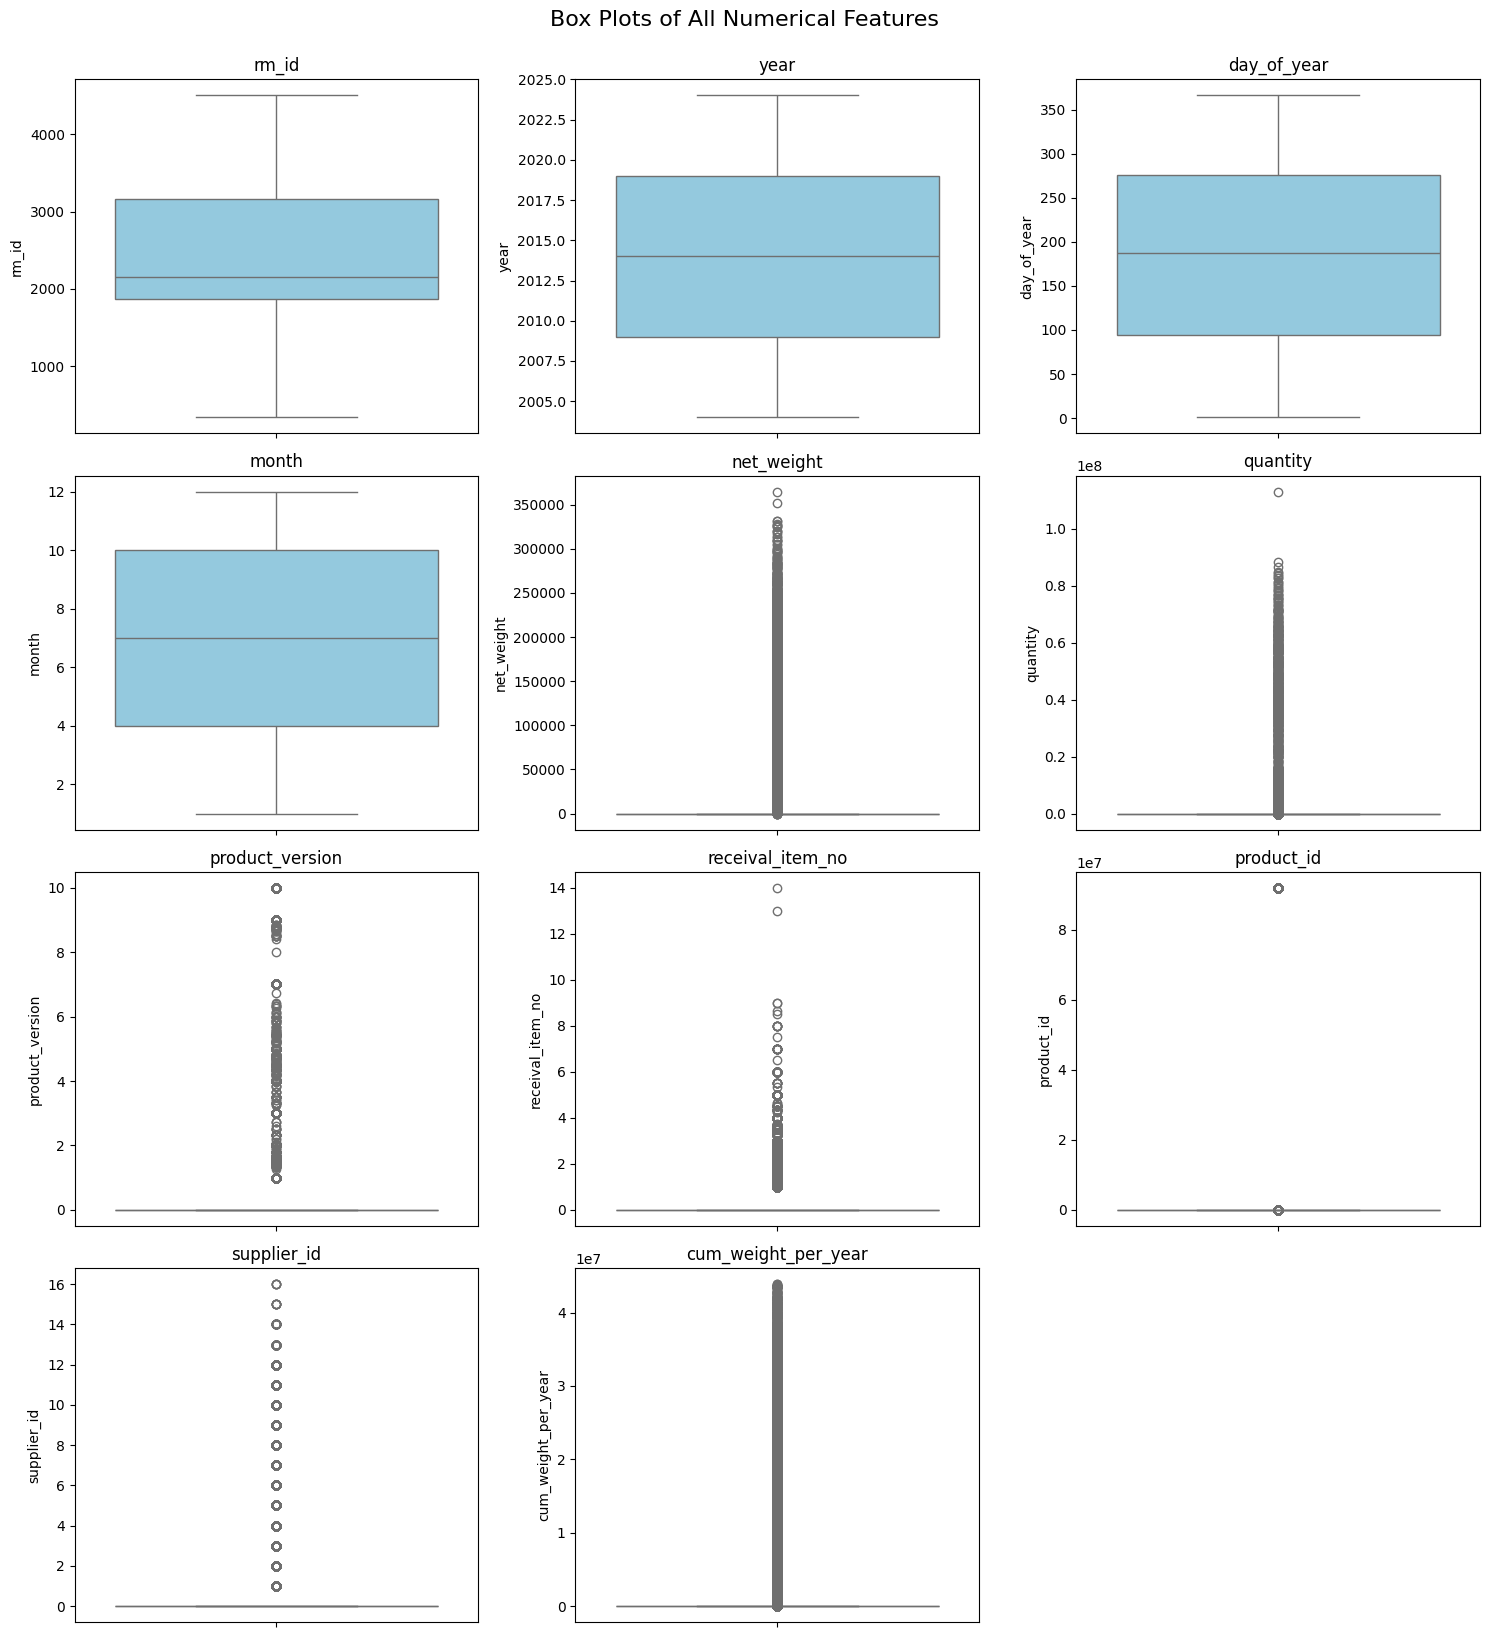

In [403]:
# Select numerical features
numeric_cols = df_rec_purchase.select_dtypes(include='number').columns

# Grid size
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_rec_purchase[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Box Plots of All Numerical Features", fontsize=16, y=1.02)
plt.show()

## RM_IDS PER YEAR

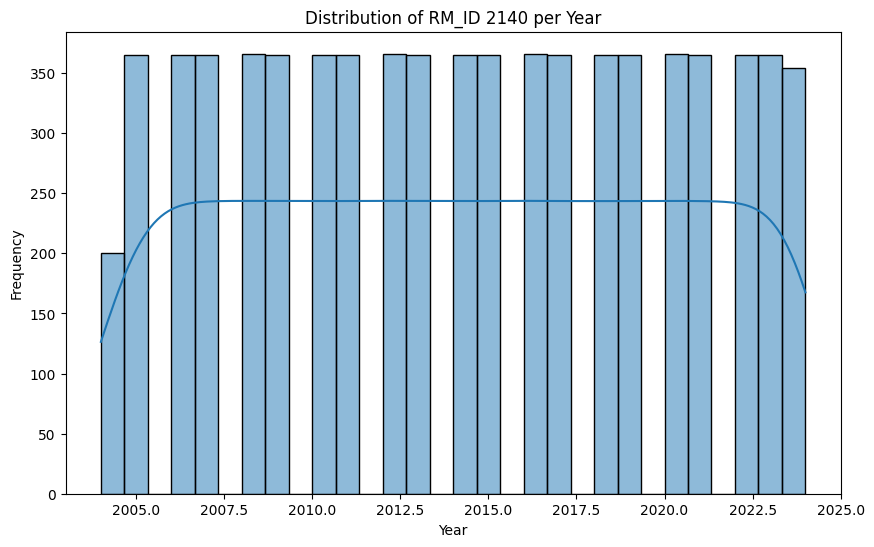

In [404]:
# distribution of rm_id 2140 per year
df_2140 = df_rec_purchase[df_rec_purchase['rm_id'] == 2140]
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df_2140, x='year', bins=30, kde=True)
plt.title('Distribution of RM_ID 2140 per Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

## PLOT NET_WEIGHT PER MONTH FOR YEARS 2024 AND 2016 FOR RM_ID = 2130 TO COMPARE

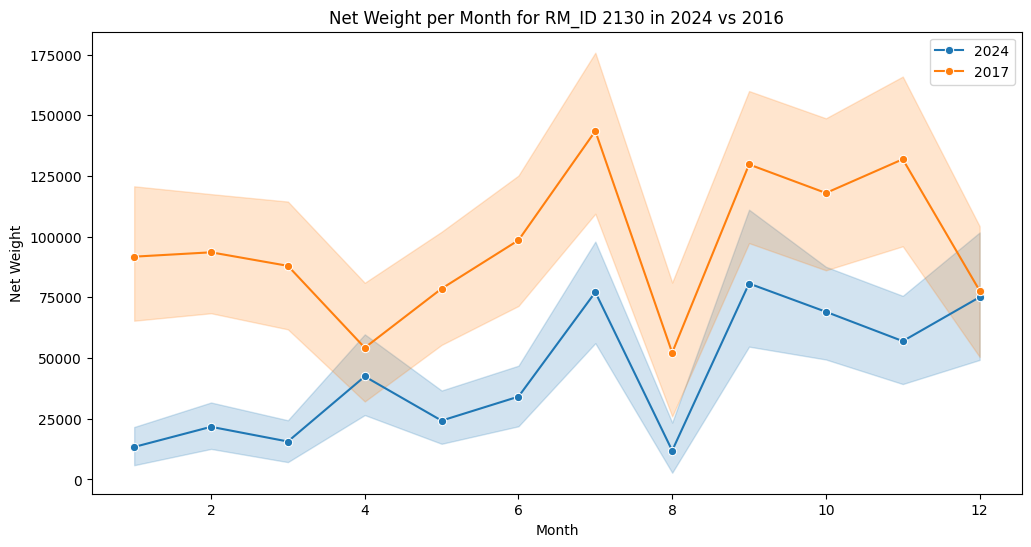

In [405]:
# PLOT NET_WEIGHT PER MONTH FOR YEARS 2024 AND 2016 FOR RM_ID = 2130 TO COMPARE
df_2130_2024 = df_rec_purchase[(df_rec_purchase['rm_id'] == 2130) & (df_rec_purchase['year'] == 2024)]
df_2130_2016 = df_rec_purchase[(df_rec_purchase['rm_id'] == 2130) & (df_rec_purchase['year'] == 2020)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2130_2024, x='month', y='net_weight', label='2024', marker='o')
sns.lineplot(data=df_2130_2016, x='month', y='net_weight', label='2017', marker='o')
plt.title('Net Weight per Month for RM_ID 2130 in 2024 vs 2016')
plt.xlabel('Month')
plt.ylabel('Net Weight')
plt.legend()
plt.show()

## REMOVE OUTLIERS BY REMOVING ROWS WITH NET_WEIGHT > 200000

In [406]:
# REMOVE OUTLIERS BY REMOVING ROWS WITH NET_WEIGHT > 200000
#df_rec_purchase = df_rec_purchase[df_rec_purchase['net_weight'] <= 200000]

## CORRELATION

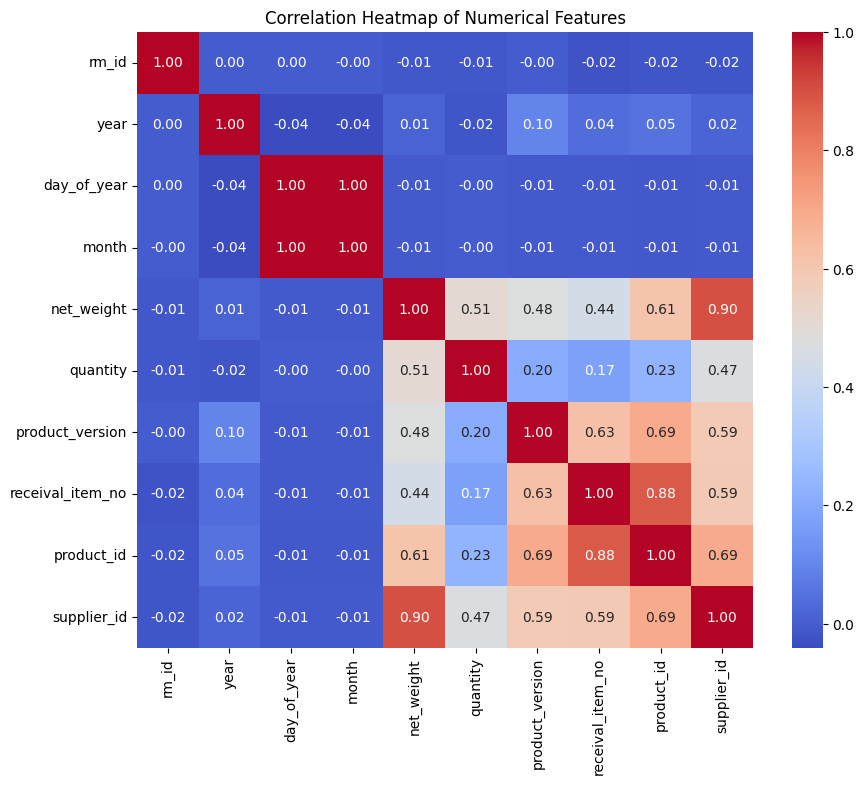

In [407]:
# correlation heatmap for numerical features
numeric_cols = [col for col in df_daily.columns if col != 'date_arrival']
plt.figure(figsize=(10, 8))
correlation_matrix = df_rec_purchase[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## REMOVE ROWS THAT HAVE RM_IDS WITH A COUNT OF 1

In [408]:
# REMOVE ROWS THAT HAVE RM_IDS WITH A COUNT OF 1
#rm_id_counts = df_rec_purchase['rm_id'].value_counts()
#df_rec_purchase = df_rec_purchase[df_rec_purchase['rm_id'].isin(rm_id_counts[rm_id_counts > 1].index)]
#print("✅ Dataset shape after removing rm_ids with single entries:", df_rec_purchase.shape)

## CREATE WEEK_OF_YEAR AND DAY_OF_WEEK

In [409]:
# Ensure date_arrival is datetime
df_rec_purchase['date_arrival'] = pd.to_datetime(df_rec_purchase['date_arrival'], errors='coerce')

# Extract week of year and day of week
df_rec_purchase['week_of_year'] = df_rec_purchase['date_arrival'].dt.isocalendar().week.astype(int)
df_rec_purchase['day_of_week'] = df_rec_purchase['date_arrival'].dt.weekday  # Monday=0, Sunday=6

## CREATE AVG_FEATURES PER RM_ID AND WEEKDAY, FOR EVERY FEATURE THATS NOT DAY_OF_YEAR, RM_ID, PURCHASE_PROB AND NET_WEIGHT

In [410]:
import pandas as pd

# ============================================================
# 1️⃣ Setup
# ============================================================
exclude_cols = ['rm_id', 'day_of_year', 'year', 'month', 'cum_weight_per_year']
numeric_cols = [c for c in df_rec_purchase.select_dtypes(include='number').columns if c not in exclude_cols + ['week_of_year', 'day_of_week']]

# Compute yearly means
yearly_avg = (
    df_rec_purchase
    .groupby(['rm_id', 'week_of_year', 'day_of_week', 'year'])[numeric_cols]
    .mean()
    .reset_index()
)

# ============================================================
# 2️⃣ Self-merge to bring in previous two years
# ============================================================
# Shift year by -1 (previous year) and -2 (two years before)
lag1 = yearly_avg.copy()
lag1['year'] += 1
lag1 = lag1.rename(columns={col: f'prev1_{col}' for col in numeric_cols})

lag2 = yearly_avg.copy()
lag2['year'] += 2
lag2 = lag2.rename(columns={col: f'prev2_{col}' for col in numeric_cols})

# Merge both lag datasets
merged = yearly_avg.merge(lag1, on=['rm_id', 'week_of_year', 'day_of_week', 'year'], how='left')
merged = merged.merge(lag2, on=['rm_id', 'week_of_year', 'day_of_week', 'year'], how='left')

# ============================================================
# 3️⃣ Compute strict 2-year average
# ============================================================
for col in numeric_cols:
    merged[f'avg_{col}'] = merged[[f'prev1_{col}', f'prev2_{col}']].mean(axis=1)

# ============================================================
# 4️⃣ Merge back to main df
# ============================================================
avg_cols = [f'avg_{c}' for c in numeric_cols]
df_rec_purchase = df_rec_purchase.merge(
    merged[['rm_id', 'week_of_year', 'day_of_week', 'year'] + avg_cols],
    on=['rm_id', 'week_of_year', 'day_of_week', 'year'],
    how='left'
)

print("✅ Strict 2-year average features created")
print(f"Shape: {df_rec_purchase.shape}")
print(df_rec_purchase.head())
# ============================================================
# ============================================================
#exclude_cols = ['rm_id', 'day_of_year', 'purchase_prob', 'year', 'month', 'day_of_year', 'cum_weight_per_year']

# ============================================================
# 2️⃣ Select numeric columns to average
# ============================================================
#numeric_cols = [
    #c for c in df_rec_purchase.select_dtypes(include='number').columns
    #if c not in exclude_cols + ['week_of_year', 'day_of_week']
#]

# ============================================================
# 3️⃣ Compute averages per (rm_id, week_of_year, day_of_week)
# ============================================================
#avg_df = (
    #df_rec_purchase
    #.groupby(['rm_id', 'week_of_year', 'day_of_week'])[numeric_cols]
    #.mean()
    #.reset_index()
#)

# Rename averaged columns with prefix
#avg_df = avg_df.rename(columns={c: f'avg_{c}' for c in numeric_cols})

# ============================================================
# 4️⃣ Merge averages back so all original rows remain
# ============================================================
#df_rec_purchase = df_rec_purchase.merge(
    #avg_df,
    #on=['rm_id', 'week_of_year', 'day_of_week'],
    #how='left'
#)

# ============================================================
# 5️⃣ Log info
# ============================================================
#print(df_rec_purchase.head())
#print(f"✅ df_rec_purchase shape: {df_rec_purchase.shape}")


#----------------------------------------------------------------------------------------
#AVERAGE PER DAY_OF_YEAR AND RM_ID
# Columns NOT to average
#exclude_cols = ['rm_id', 'day_of_year', 'purchase_prob', 'net_weight', 'year', 'month']

# Numeric columns to average
#numeric_cols = [c for c in df_rec_purchase.select_dtypes(include='number').columns if c not in exclude_cols]

# Compute averages per (rm_id, day_of_year)
#avg_df = df_rec_purchase.groupby(['rm_id', 'day_of_year'])[numeric_cols].mean().reset_index()
#avg_df = avg_df.rename(columns={c: f'avg_{c}' for c in numeric_cols})

# Merge averages back onto the original df so **all original rows remain**
#df_rec_purchase = df_rec_purchase.merge(avg_df, on=['rm_id', 'day_of_year'], how='left')

# Keep purchase_prob, net_weight, year, month as is
# (they were never removed)
#print(df_rec_purchase.head())
#print(f"✅ df_rec_purchase shape: {df_rec_purchase.shape}")

✅ Strict 2-year average features created
Shape: (1423670, 20)
   rm_id date_arrival  year  day_of_year  month  net_weight  quantity  \
0  342.0   2004-06-15  2004          167      6         0.0       0.0   
1  342.0   2004-06-16  2004          168      6         0.0       0.0   
2  342.0   2004-06-17  2004          169      6         0.0       0.0   
3  342.0   2004-06-18  2004          170      6         0.0       0.0   
4  342.0   2004-06-19  2004          171      6         0.0       0.0   

   product_version  receival_item_no  product_id  supplier_id  \
0              0.0               0.0         0.0          0.0   
1              0.0               0.0         0.0          0.0   
2              0.0               0.0         0.0          0.0   
3              0.0               0.0         0.0          0.0   
4              0.0               0.0         0.0          0.0   

   cum_weight_per_year  week_of_year  day_of_week  avg_net_weight  \
0                  0.0            25   

## lag feature

In [411]:
import pandas as pd

# ============================================================
# 0️⃣ Ensure proper ordering
# ============================================================
df_rec_purchase = df_rec_purchase.sort_values(['rm_id', 'date_arrival']).reset_index(drop=True)

# ============================================================
# 1️⃣ Compute lag features (1, 7, 30 days) within each rm_id
# ============================================================
lag_features = df_rec_purchase[['rm_id', 'year', 'week_of_year', 'day_of_week', 'cum_weight_per_year']].copy()

# Sort by rm_id and temporal order
lag_features = lag_features.sort_values(['rm_id', 'year', 'week_of_year', 'day_of_week'])

# Compute lags inside each rm_id
lag_features['lag1_cum_weight_per_year'] = lag_features.groupby('rm_id')['cum_weight_per_year'].shift(1)
lag_features['lag7_cum_weight_per_year'] = lag_features.groupby('rm_id')['cum_weight_per_year'].shift(7)
lag_features['lag30_cum_weight_per_year'] = lag_features.groupby('rm_id')['cum_weight_per_year'].shift(30)

# ============================================================
# 2️⃣ Create next-year alignment (shift forward one year)
# ============================================================
# Increment year to align previous-year lags with current-year rows
lag_features['year'] = lag_features['year'] + 1

# Rename columns to indicate they're from the previous year
lag_features = lag_features.rename(columns={
    'cum_weight_per_year': 'cum_weight_per_year_prev_year',
    'lag1_cum_weight_per_year': 'lag1_cum_weight_per_year_prev_year',
    'lag7_cum_weight_per_year': 'lag7_cum_weight_per_year_prev_year',
    'lag30_cum_weight_per_year': 'lag30_cum_weight_per_year_prev_year'
})

# Keep only needed columns
lag_features = lag_features[[
    'rm_id', 'year', 'week_of_year', 'day_of_week',
    'cum_weight_per_year_prev_year',
    'lag1_cum_weight_per_year_prev_year',
    'lag7_cum_weight_per_year_prev_year',
    'lag30_cum_weight_per_year_prev_year'
]]

# ============================================================
# 3️⃣ Merge all prev-year features into the main dataframe
# ============================================================
df_rec_purchase = df_rec_purchase.merge(
    lag_features,
    on=['rm_id', 'year', 'week_of_year', 'day_of_week'],
    how='left'
)

# ============================================================
# 4️⃣ (Optional) Drop old roll2yr feature if it exists
# ============================================================
if 'roll2yr_cum_weight_per_year' in df_rec_purchase.columns:
    df_rec_purchase = df_rec_purchase.drop(columns=['roll2yr_cum_weight_per_year'])
    print("Dropped old roll2yr_cum_weight_per_year column.")

# ============================================================
# 5️⃣ Quick check
# ============================================================
cols_show = [
    'rm_id', 'date_arrival', 'year', 'week_of_year', 'day_of_week',
    'cum_weight_per_year',
    'cum_weight_per_year_prev_year',
    'lag1_cum_weight_per_year_prev_year',
    'lag7_cum_weight_per_year_prev_year',
    'lag30_cum_weight_per_year_prev_year'
]

print("✅ Created cum_weight_per_year_prev_year + lag1, lag7, lag30 previous-year features.")
print(df_rec_purchase[cols_show].head(20))

✅ Created cum_weight_per_year_prev_year + lag1, lag7, lag30 previous-year features.
    rm_id date_arrival  year  week_of_year  day_of_week  cum_weight_per_year  \
0   342.0   2004-06-15  2004            25            1                  0.0   
1   342.0   2004-06-16  2004            25            2                  0.0   
2   342.0   2004-06-17  2004            25            3                  0.0   
3   342.0   2004-06-18  2004            25            4                  0.0   
4   342.0   2004-06-19  2004            25            5                  0.0   
5   342.0   2004-06-20  2004            25            6                  0.0   
6   342.0   2004-06-21  2004            26            0                  0.0   
7   342.0   2004-06-22  2004            26            1                  0.0   
8   342.0   2004-06-23  2004            26            2              24940.0   
9   342.0   2004-06-24  2004            26            3              24940.0   
10  342.0   2004-06-25  2004        

## CREATE ROLLING AVERAGES FOR MULTIPLE FEATURES

In [412]:
import pandas as pd


# ============================================================
# 1️⃣ Features to compute rolling 2-year averages for
# ============================================================
#rolling_features = [
    #'net_weight', 
    #'quantity', 
    #'supplier_id'
#]

# Ensure time-based features exist
#if 'week_of_year' not in df_rec_purchase.columns or 'day_of_week' not in df_rec_purchase.columns:
    #df_rec_purchase['date'] = pd.to_datetime(df_rec_purchase['date'], errors='coerce')
    #df_rec_purchase['week_of_year'] = df_rec_purchase['date'].dt.isocalendar().week.astype(int)
    #df_rec_purchase['day_of_week'] = df_rec_purchase['date'].dt.weekday

# ============================================================
# 2️⃣ Sort values properly before rolling
# ============================================================
#df_roll = df_rec_purchase.sort_values(['rm_id', 'week_of_year', 'day_of_week', 'year']).copy()

# ============================================================
# 3️⃣ Compute rolling means over last 2 years per RM_ID + week/day
# ============================================================
#for feat in rolling_features:
    #df_roll[f'roll2yr_{feat}'] = (
        #df_roll.groupby(['rm_id', 'week_of_year', 'day_of_week'])[feat]
        #.rolling(window=2, min_periods=1)
        #.mean()
        #.reset_index(level=[0,1,2], drop=True)
    #)

# ============================================================
# 4️⃣ Merge rolling averages back into df_rec_purchase
# ============================================================
#for feat in rolling_features:
    #df_rec_purchase[f'roll2yr_{feat}'] = df_roll[f'roll2yr_{feat}']

# ============================================================
# 5️⃣ Done
# ============================================================
#print(f"✅ df_rec_purchase shape with rolling 2-year features: {df_rec_purchase.shape}")
#print(df_rec_purchase.head())

#--------------------------------------------------------------------
#AVERAGE PER DAY_OF_YEAR AND RM_ID - 2 YEAR ROLLING AVERAGES
# Features to compute rolling averages for
#rolling_features = [
    #'net_weight', 
    #'gross_weight', 
    #'quantity', 
    #'impurity_deduction_weight',
    #'vehicle_start_weight', 
    #'vehicle_end_weight', 
    #'tare_weight', 
    #'supplier_id',
    #'vehicle_no'
#]

# Sort by RM_ID, day_of_year, year
#df_roll = df_rec_purchase.sort_values(['rm_id', 'day_of_year', 'year']).copy()

# Compute rolling averages
#for feat in rolling_features:
    #df_roll[f'roll2yr_{feat}'] = (
        #df_roll.groupby(['rm_id', 'day_of_year'])[feat]
        #.rolling(window=2, min_periods=1)  # last 2 years
        #.mean()
        #.reset_index(level=[0,1], drop=True)
    #)

# Merge rolling features into df_rec_purchase (already aligned by index)
#for feat in rolling_features:
    #df_rec_purchase[f'roll2yr_{feat}'] = df_roll[f'roll2yr_{feat}']

#print(f"✅ df_rec_purchase shape with rolling features: {df_rec_purchase.shape}")
#print(df_rec_purchase.head())

# ============================================================
# ============================================================
# NOW FIXED ROLLING AVERAGES PER WEEK_OF_YEAR AND DAY_OF_WEEK

#rolling_features = ['cum_weight_per_year']
#roll_results = []

#for feat in rolling_features:
    # 1️⃣ Yearly mean per (rm_id, week_of_year, day_of_week, year)
    #yearly = (
        #df_rec_purchase
        #.groupby(['rm_id', 'week_of_year', 'day_of_week', 'year'], as_index=False)[feat]
        #.mean()
        #.rename(columns={feat: 'yearly_mean'})
    #)

    # 2️⃣ Prepare previous year (Y-1) and two years before (Y-2)
    #prev1 = yearly.copy()
    #prev1['year'] += 1
    #prev1 = prev1.rename(columns={'yearly_mean': 'prev1_' + feat})

    #prev2 = yearly.copy()
    #prev2['year'] += 2
    #prev2 = prev2.rename(columns={'yearly_mean': 'prev2_' + feat})

    # 3️⃣ Merge both lags to current year
    #merged = yearly.merge(prev1, on=['rm_id', 'week_of_year', 'day_of_week', 'year'], how='left')
    #merged = merged.merge(prev2, on=['rm_id', 'week_of_year', 'day_of_week', 'year'], how='left')

    # 4️⃣ Compute strict 2-year average
    #merged['roll2yr_' + feat] = merged[[f'prev1_{feat}', f'prev2_{feat}']].mean(axis=1)

    #roll_results.append(merged[['rm_id', 'week_of_year', 'day_of_week', 'year', 'roll2yr_' + feat]])

# 5️⃣ Merge back into original dataset
#for df_roll_feat in roll_results:
    #df_rec_purchase = df_rec_purchase.merge(
        #df_roll_feat,
        #on=['rm_id', 'week_of_year', 'day_of_week', 'year'],
        #how='left'
    #)

#df_rec_purchase = df_rec_purchase.fillna(0)

#print(f"✅ df_rec_purchase shape with strict 2-year rolling features: {df_rec_purchase.shape}")
#print(df_rec_purchase.head())

## DROP PURCHASE_PROB AND CREATE NEW FEATURE PURCHASE_PROB WHICH GIVES THE AVERAGES OF PURCHASE_PROB FROM YEAR BEFORE IN: JANUARY TO JUNE (IF ROW AFTER JUNE) OR FROM JULY TO DECEMBER IF ROW IS JAN-JUN

In [413]:
# Copy main dataset
df = df_rec_purchase.copy()
df['date_arrival'] = pd.to_datetime(df['date_arrival'], errors='coerce')
df['year'] = df['date_arrival'].dt.year
df['month'] = df['date_arrival'].dt.month

# Purchase flag (1 if any purchase, else 0)
df['purchase_flag'] = (df['net_weight'] > 0).astype(int)

# --------------------------------------------------------
# 1️⃣ Monthly purchase probability per RM_ID
# --------------------------------------------------------
monthly_prob = (
    df.groupby(['rm_id', 'year', 'month'], as_index=False)
      .agg(
          total_days=('date_arrival', 'nunique'),
          days_with_purchase=('purchase_flag', 'sum')
      )
)
monthly_prob['purchase_prob'] = monthly_prob['days_with_purchase'] / monthly_prob['total_days']

# Month start for sorting & rolling
monthly_prob['month_start'] = pd.to_datetime(
    monthly_prob['year'].astype(str) + '-' + monthly_prob['month'].astype(str) + '-01'
)
monthly_prob = monthly_prob.sort_values(['rm_id', 'month_start'])

# --------------------------------------------------------
# 2️⃣ Rolling 3-month mean of purchase_prob (previous months only)
# --------------------------------------------------------
monthly_prob['prev_purchase_prob'] = (
    monthly_prob.groupby('rm_id')['purchase_prob']
    .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).mean())
    .reset_index(level=0, drop=True)
)

# --------------------------------------------------------
# 3️⃣ Drop early-year rows with NA (not enough 3-month history)
# --------------------------------------------------------
first_year = monthly_prob['year'].min()
monthly_prob.loc[monthly_prob['year'] == first_year, 'prev_purchase_prob'] = np.nan
monthly_prob = monthly_prob.dropna(subset=['prev_purchase_prob'])

# --------------------------------------------------------
# 4️⃣ Merge back to main df
# --------------------------------------------------------
df = df.merge(
    monthly_prob[['rm_id', 'year', 'month', 'prev_purchase_prob',
                  'days_with_purchase', 'total_days']],
    on=['rm_id', 'year', 'month'],
    how='left'
)

# --------------------------------------------------------
# 5️⃣ Cleanup
# --------------------------------------------------------
df = df.drop(columns=['purchase_flag'])
df_rec_purchase = df

# --------------------------------------------------------
# ✅ Preview
# --------------------------------------------------------
print(df_rec_purchase[['rm_id','date_arrival','year','month',
                       'days_with_purchase','total_days','prev_purchase_prob']].head(15))

    rm_id date_arrival  year  month  days_with_purchase  total_days  \
0   342.0   2004-06-15  2004      6                 NaN         NaN   
1   342.0   2004-06-16  2004      6                 NaN         NaN   
2   342.0   2004-06-17  2004      6                 NaN         NaN   
3   342.0   2004-06-18  2004      6                 NaN         NaN   
4   342.0   2004-06-19  2004      6                 NaN         NaN   
5   342.0   2004-06-20  2004      6                 NaN         NaN   
6   342.0   2004-06-21  2004      6                 NaN         NaN   
7   342.0   2004-06-22  2004      6                 NaN         NaN   
8   342.0   2004-06-23  2004      6                 NaN         NaN   
9   342.0   2004-06-24  2004      6                 NaN         NaN   
10  342.0   2004-06-25  2004      6                 NaN         NaN   
11  342.0   2004-06-26  2004      6                 NaN         NaN   
12  342.0   2004-06-27  2004      6                 NaN         NaN   
13  34

## DROP ROWS WITH NA VALUES, WHHICH ARE THE ONES IN 2004. MAKES NO DIFFERENCE AS THE ONES THAT ACTUALLY HAVE VALUES THERE DONT NEED TO BE PREDICTED FOR 2025. 

In [414]:
# DROP ROWS WITH NA VALUES
df_rec_purchase = df_rec_purchase.dropna()

## ADDING RATIO AND RELATIONSHIP FEATURES BETWEEN LAG AND ROLLING CUM_WEIGHT

In [415]:
import numpy as np

# ============================================================
# 1️⃣ Ensure required columns exist
# ============================================================
required_cols = ['lag1_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year']
missing = [c for c in required_cols if c not in df_rec_purchase.columns]
if missing:
    raise KeyError(f"Missing required columns in df_rec_purchase: {missing}")

# ============================================================
# 2️⃣ Compute difference (delta) and ratio between lag and actual previous-year cumulative
# ============================================================
df_rec_purchase['delta_lastyear_vs_prevyear'] = (
    df_rec_purchase['lag7_cum_weight_per_year_prev_year'] -
    df_rec_purchase['cum_weight_per_year_prev_year']
)

df_rec_purchase['ratio_lastyear_over_prevyear'] = np.where(
    df_rec_purchase['cum_weight_per_year_prev_year'] != 0,
    df_rec_purchase['lag7_cum_weight_per_year_prev_year'] / df_rec_purchase['cum_weight_per_year_prev_year'],
    np.nan  # ✅ this is the missing "else" value — use np.nan or 0
)

# ============================================================
# 3️⃣ Inspect result
# ============================================================
print("✅ Added delta_lastyear_vs_prevyear and ratio_lastyear_over_prevyear to df_rec_purchase")
print(df_rec_purchase[['rm_id', 'year', 'week_of_year', 'day_of_week',
                       'cum_weight_per_year_prev_year',
                       'lag7_cum_weight_per_year_prev_year',
                       'delta_lastyear_vs_prevyear',
                       'ratio_lastyear_over_prevyear']].head(10))

✅ Added delta_lastyear_vs_prevyear and ratio_lastyear_over_prevyear to df_rec_purchase
     rm_id  year  week_of_year  day_of_week  cum_weight_per_year_prev_year  \
401  342.0  2005            29            3                        24940.0   
402  342.0  2005            29            4                        24940.0   
403  342.0  2005            29            5                        24940.0   
404  342.0  2005            29            6                        24940.0   
405  342.0  2005            30            0                        24940.0   
406  342.0  2005            30            1                        24940.0   
407  342.0  2005            30            2                        24940.0   
408  342.0  2005            30            3                        24940.0   
409  342.0  2005            30            4                        24940.0   
410  342.0  2005            30            5                        24940.0   

     lag7_cum_weight_per_year_prev_year  delta_lastyea

C:\Users\bupat\AppData\Local\Temp\ipykernel_19740\715533143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec_purchase['delta_lastyear_vs_prevyear'] = (
C:\Users\bupat\AppData\Local\Temp\ipykernel_19740\715533143.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec_purchase['ratio_lastyear_over_prevyear'] = np.where(


## TRYING TEMPORAL EFFECTS

In [416]:
df_rec_purchase['quarter'] = df_rec_purchase['date_arrival'].dt.quarter

# --- Cyclical encoding for periodic effects (sin/cos for continuous seasonality)
df_rec_purchase['sin_doy'] = np.sin(2 * np.pi * df_rec_purchase['day_of_year'] / 365)
df_rec_purchase['cos_doy'] = np.cos(2 * np.pi * df_rec_purchase['day_of_year'] / 365)

# ============================================================
# ✅ Print summary
# ============================================================
temporal_cols = [
    'year', 'week_of_year',
    'sin_doy', 'cos_doy'
]
print(f"✅ Added {len(temporal_cols)} temporal features.")
print("🧩 Temporal feature preview:")
display(df_rec_purchase[temporal_cols].head())

✅ Added 4 temporal features.
🧩 Temporal feature preview:


C:\Users\bupat\AppData\Local\Temp\ipykernel_19740\2441069943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec_purchase['quarter'] = df_rec_purchase['date_arrival'].dt.quarter
C:\Users\bupat\AppData\Local\Temp\ipykernel_19740\2441069943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec_purchase['sin_doy'] = np.sin(2 * np.pi * df_rec_purchase['day_of_year'] / 365)
C:\Users\bupat\AppData\Local\Temp\ipykernel_19740\2441069943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a cop

,year,week_of_year,sin_doy,cos_doy
401,2005,29,-0.329408,-0.944188
402,2005,29,-0.345612,-0.938377
403,2005,29,-0.361714,-0.932289
404,2005,29,-0.377708,-0.925925
405,2005,30,-0.393590,-0.919286


## DROP THE FEATURES THAT ARENT AVERAGES

In [417]:
# Example: your exclude columns list
exclude_cols = ['rm_id', 'day_of_year', 'prev_purchase_prob', 'year', 'month', 'week_of_year', 'day_of_week', 'date_arrival', 'cum_weight_per_year']

# Keep only averaged, rolling, excluded, and last-year lag features
df_model = df_rec_purchase[
    [
        c for c in df_rec_purchase.columns
        if (
            c.startswith('avg_') or
            c.startswith('roll2yr_') or
            c in exclude_cols or
            c in temporal_cols or
            c == 'lag1_cum_weight_per_year_prev_year' or 
            c == 'lag7_cum_weight_per_year_prev_year' or 
            c == 'cum_weight_per_year_prev_year' or 
            c == 'lag30_cum_weight_per_year_prev_year' or 
            c == 'delta_lastyear_vs_prevyear' or
            c == 'ratio_lastyear_over_prevyear'  # ✅ explicitly keep this
        )
    ]
].copy()

print(f"✅ Cleaned df_rec_purchase shape: {df_model.shape}")
print(df_model.head())

✅ Cleaned df_rec_purchase shape: (1341780, 23)
     rm_id date_arrival  year  day_of_year  month  cum_weight_per_year  \
401  342.0   2005-07-21  2005          202      7                  0.0   
402  342.0   2005-07-22  2005          203      7                  0.0   
403  342.0   2005-07-23  2005          204      7                  0.0   
404  342.0   2005-07-24  2005          205      7                  0.0   
405  342.0   2005-07-25  2005          206      7                  0.0   

     week_of_year  day_of_week  avg_net_weight  avg_quantity  ...  \
401            29            3             0.0           0.0  ...   
402            29            4             0.0           0.0  ...   
403            29            5             0.0           0.0  ...   
404            29            6             0.0           0.0  ...   
405            30            0             0.0           0.0  ...   

     avg_supplier_id  cum_weight_per_year_prev_year  \
401              0.0                  

## CORRELATION NOW

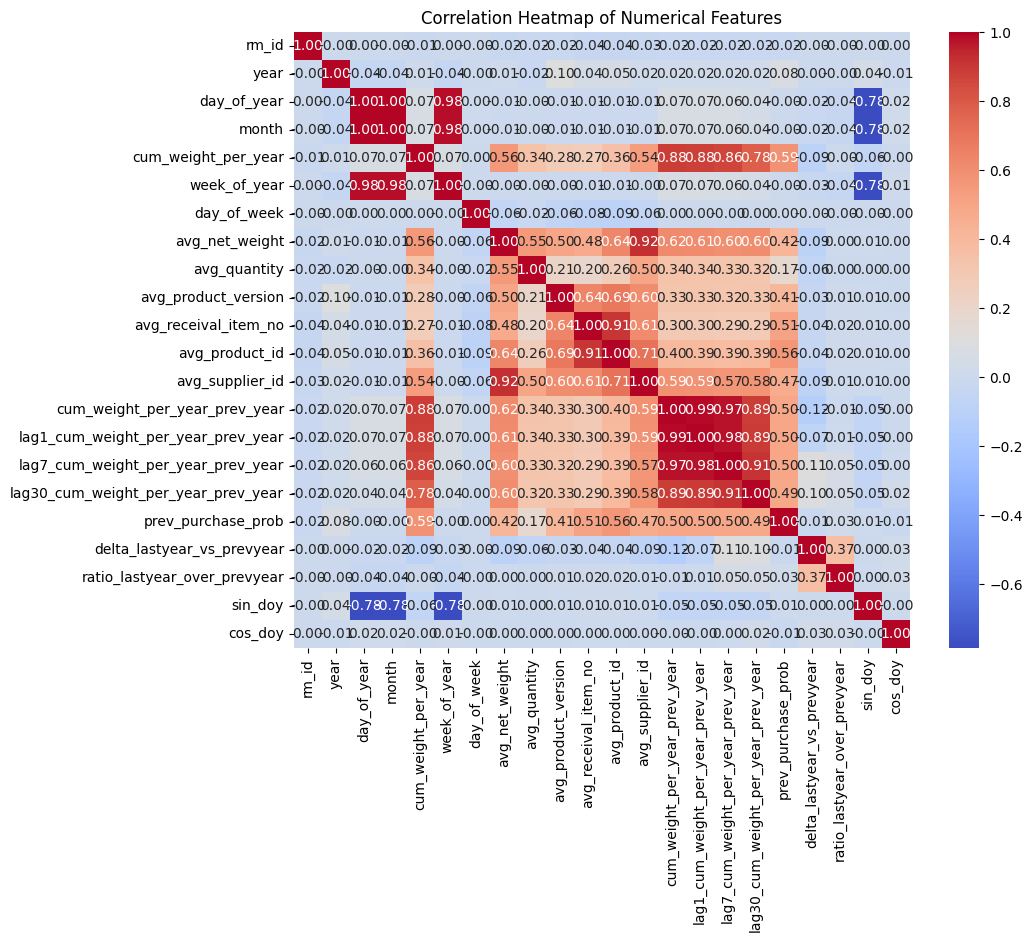

In [418]:
## # correlation heatmap for numerical features
numeric_cols = [col for col in df_model.columns if col != 'date_arrival']
plt.figure(figsize=(10, 8))
correlation_matrix = df_model[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## DROP AVG_GROSS_WEIGHT, AVG_MONTH AND AVG_YEAR

In [419]:
# DROP AVG_GROSS_WEIGHT, AVG_MONTH AND AVG_YEAR
#df_rec_purchase = df_rec_purchase.drop(columns=['avg_gross_weight'])

## AFTER MODEL INTERPRETATION, DROP THESE FEATURES

## DEFINING METRICS AND DATA PREP FOR VALIDATION

In [426]:
# =====================================================
# 1. Imports & Setup
# =====================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform

# =====================================================
# 2. Custom Quantile Error Metric
# =====================================================

class ParticipantVisibleError(Exception):
    """Raise this for participant-facing errors."""
    pass


def quantile_error(actual: np.ndarray, predicted: np.ndarray, q: float = 0.2) -> float:
    """Quantile loss (pinball loss) for quantile q."""
    if np.any(actual < 0) or np.any(predicted < 0):
        raise ParticipantVisibleError("Values must be non-negative.")

    diff = actual - predicted
    return np.mean(np.maximum(q * diff, (q - 1) * diff))


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "ID") -> float:
    """Compute 0.2 quantile error between true and predicted weights."""
    for col in [row_id_column_name, 'predicted_weight']:
        if col not in submission.columns:
            raise ParticipantVisibleError(f"Submission is missing column: {col}")
    if not pd.api.types.is_numeric_dtype(submission['predicted_weight']):
        raise ParticipantVisibleError("'predicted_weight' in submission must be numeric.")

    submission_filtered = submission[submission[row_id_column_name].isin(solution[row_id_column_name])]
    merged = pd.merge(solution, submission_filtered, on=row_id_column_name, how='left', validate='one_to_one')

    if merged['predicted_weight'].isnull().any():
        missing_ids = merged.loc[merged['predicted_weight'].isnull(), row_id_column_name].tolist()
        raise ParticipantVisibleError(f"Missing predictions for ID(s): {missing_ids[:5]}")

    actual = merged['weight'].values
    predicted = merged['predicted_weight'].values
    result = quantile_error(actual, predicted, q=0.2)

    if not np.isfinite(result):
        raise ParticipantVisibleError("Final quantile error is not finite.")
    return float(result)


# =====================================================
# 3. Prepare Data
# =====================================================

df = df_model.copy()
df['date_arrival'] = pd.to_datetime(df['date_arrival'], errors='coerce')

target = 'cum_weight_per_year'

base_exclude = [
    'date_arrival', 'day_of_year', 'cum_weight_per_year',
    'avg_product_version', 'avg_product_id', 'avg_quantity',
    'avg_receival_item_no', 'day_of_week', 'avg_supplier_id'
]

# ✅ Build feature list (force include lag feature)
features = [
    col for col in df.columns
    if col not in base_exclude
    #and col not in ['year', 'month', 'day_of_year']
    and col in temporal_cols
] + ['lag1_cum_weight_per_year_prev_year', 'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear', 'prev_purchase_prob', 'lag7_cum_weight_per_year_prev_year', 'lag30_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year']

print(features)

X = df[features]
y = df[target]

# One-hot encode categorical variables if any
X = pd.get_dummies(X, drop_first=True)

# =====================================================
# 3️⃣ Define Time-Based Train/Validation Split
# =====================================================
df_rec_purchase['date_arrival'] = pd.to_datetime(df_rec_purchase['date_arrival'], errors='coerce')

cutoff_start = pd.Timestamp('2024-01-01')
cutoff_end = pd.Timestamp('2024-12-31')

is_valid = (df_rec_purchase['date_arrival'] >= cutoff_start) & (df_rec_purchase['date_arrival'] <= cutoff_end)
is_train = ~is_valid

# Sample weights: emphasize recent years
sample_weights = np.where(df['year'] == 2024, 5.0,
                  np.where(df['year'] == 2023, 3.0, 1.0))

X_train, y_train, w_train = X[is_train], y[is_train], sample_weights[is_train]
X_valid, y_valid, w_valid = X[is_valid], y[is_valid], sample_weights[is_valid]

print(f"🧩 Train: {len(X_train):,} | Valid: {len(X_valid):,}")
print(f"Train Range: {df_rec_purchase.loc[is_train, 'date_arrival'].min().date()} → {df_rec_purchase.loc[is_train, 'date_arrival'].max().date()}")
print(f"Valid Range: {df_rec_purchase.loc[is_valid, 'date_arrival'].min().date()} → {df_rec_purchase.loc[is_valid, 'date_arrival'].max().date()}")

def quantile_scorer(y_true, y_pred):
    return -quantile_error(y_true, y_pred, q=0.2)  # negative because sklearn maximizes the score

custom_scorer = make_scorer(quantile_scorer, greater_is_better=True)

['year', 'week_of_year', 'sin_doy', 'cos_doy', 'lag1_cum_weight_per_year_prev_year', 'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear', 'prev_purchase_prob', 'lag7_cum_weight_per_year_prev_year', 'lag30_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year']
🧩 Train: 1,274,520 | Valid: 67,260
Train Range: 2005-07-21 → 2023-12-31
Valid Range: 2024-01-01 → 2024-12-19


## RF

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint, uniform
#import numpy as np
#import pandas as pd

# ---------------------------
# Subset for faster hyperparameter tuning
# ---------------------------
#subset_frac = 0.25  # 25% of training data
#X_tune = X_train.sample(frac=subset_frac, random_state=42)

# Get integer positions of sampled rows
#subset_idx = X_tune.index
#subset_pos = X_train.index.get_indexer(subset_idx)  # ensures correct alignment even for numpy arrays

# Handle y_train safely
#if isinstance(y_train, pd.Series):
    #y_tune = y_train.loc[subset_idx]
#else:
    #y_tune = y_train[subset_pos]

# Handle w_train safely
#if isinstance(w_train, pd.Series):
    #w_tune = w_train.loc[subset_idx]
#else:
    #w_tune = w_train[subset_pos]

# ---------------------------
# Define Random Forest
# ---------------------------
#rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#param_dist_rf = {
    #'n_estimators': randint(100, 500),
    #'max_depth': randint(6, 30),
    #'min_samples_split': randint(2, 15),
    #'min_samples_leaf': randint(1, 8),
    #'max_features': ['sqrt', 'log2'],
    #'bootstrap': [True],
#}

# ---------------------------
# RandomizedSearchCV (subset)
# ---------------------------
#rf_search = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_dist_rf,
    #n_iter=15,
    #scoring=custom_scorer,
    #cv=3,
    #random_state=42,
    #n_jobs=-1,
    #verbose=2
#)

# Fit on subset
#rf_search.fit(X_tune, y_tune, sample_weight=w_tune)

#best_rf = rf_search.best_estimator_
#print("\n✅ Best Random Forest Params (subset tuning):")
#print(rf_search.best_params_)

# ---------------------------
# Refit on full training data
# ---------------------------
#best_rf.set_params(n_estimators=800)  # final number of trees
#best_rf.fit(X_train, y_train, sample_weight=w_train)

# ---------------------------
# Predict + Evaluate
# ---------------------------
#rf_pred = best_rf.predict(X_valid)
#rf_val_score = quantile_error(y_valid.values, rf_pred, q=0.2)
#print(f"✅ Random Forest Validation Quantile Error (q=0.2): {rf_val_score:.5f}")


## XGB

In [427]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform, loguniform

# =====================================================
# 5️⃣ Subset for tuning (25%)
# =====================================================
subset_frac = 0.25
X_tune = X_train.sample(frac=subset_frac, random_state=42)
subset_idx = X_tune.index
subset_pos = X_train.index.get_indexer(subset_idx)

if isinstance(y_train, pd.Series):
    y_tune = y_train.loc[subset_idx]
else:
    y_tune = y_train[subset_pos]

if isinstance(w_train, pd.Series):
    w_tune = w_train.loc[subset_idx]
else:
    w_tune = w_train[subset_pos]

# =====================================================
# 6️⃣ XGBoost model setup
# =====================================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',   # optimized for CPU
    predictor='auto',
    random_state=42,
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': randint(300, 800),
    'learning_rate': loguniform(0.01, 0.15),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': loguniform(1e-4, 5),
    'reg_lambda': loguniform(1e-3, 5),
    'gamma': uniform(0, 1)
}

# =====================================================
# 7️⃣ Randomized SearchCV on subset
# =====================================================
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=15,
    scoring=custom_scorer,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_tune, y_tune, sample_weight=w_tune)

best_xgb = xgb_search.best_estimator_
print("\n✅ Best XGBoost Params:")
print(xgb_search.best_params_)

# =====================================================
# 8️⃣ Fit best model on full train (2005–2023)
# =====================================================
best_xgb.fit(X_train, y_train, sample_weight=w_train)

# =====================================================
# 9️⃣ Validation (2024)
# =====================================================
xgb_pred_valid = np.maximum(0, best_xgb.predict(X_valid))
xgb_val_score = quantile_error(y_valid.values, xgb_pred_valid, q=q)

print(f"✅ Validation Quantile Error (q={q}): {xgb_val_score:.5f}")

# =====================================================
# 🔟 Retrain on full data (2005–2024)
# =====================================================
best_xgb.fit(X, y, sample_weight=sample_weights)
print("✅ Retrained on full dataset (2005–2024).")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:45:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best XGBoost Params:
{'colsample_bytree': np.float64(0.8123620356542087), 'gamma': np.float64(0.9507143064099162), 'learning_rate': np.float64(0.07259248719561363), 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 402, 'reg_alpha': np.float64(0.012443849002616567), 'reg_lambda': np.float64(0.0023431722468023933), 'subsample': np.float64(0.8377746675897602)}


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:45:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Validation Quantile Error (q=0.2): 39132.36244


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:45:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Retrained on full dataset (2005–2024).


## LIGHTGBM

In [428]:
import lightgbm as lgb
import numpy as np
import pandas as pd

subset_frac = 0.25
X_train_sub = X_train.sample(frac=subset_frac, random_state=42)

subset_idx = X_train_sub.index
subset_pos = X_train.index.get_indexer(subset_idx)

if isinstance(y_train, pd.Series):
    y_train_sub = y_train.loc[subset_idx]
else:
    y_train_sub = y_train[subset_pos]

if isinstance(w_train, pd.Series):
    w_train_sub = w_train.loc[subset_idx]
else:
    w_train_sub = w_train[subset_pos]

# =====================================================
# 4️⃣ Prepare LightGBM datasets
# =====================================================
lgb_train = lgb.Dataset(X_train_sub, label=y_train_sub, weight=w_train_sub)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, weight=w_valid)

# =====================================================
# 5️⃣ Choose compute device (GPU if available)
# =====================================================
try:
    _ = lgb.train({"device": "gpu", "verbose": -1},
                  lgb.Dataset(np.random.rand(10, 3), label=np.random.rand(10)))
    device_type = "gpu"
except Exception:
    device_type = "cpu"

print(f"⚙️ Training LightGBM on device: {device_type.upper()}")

# =====================================================
# 6️⃣ Define parameters
# =====================================================
lgb_params = {
    'objective': 'quantile',
    'alpha': q,
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 500,
    'max_depth': 12,
    'min_data_in_leaf': 40,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.05,
    'lambda_l2': 0.1,
    'boost_from_average': False,
    'verbosity': -1,
    'device': device_type
}

# =====================================================
# 7️⃣ Train model (handle version differences)
# =====================================================
import lightgbm
lgb_version = tuple(map(int, lightgbm.__version__.split('.')[:2]))

if lgb_version >= (4, 0):
    callbacks = [
        lgb.early_stopping(stopping_rounds=30, verbose=True),
        lgb.log_evaluation(period=50)
    ]
    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=callbacks
    )
else:
    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=30,
        verbose_eval=50
    )

# =====================================================
# 8️⃣ Validation (2024)
# =====================================================
lgb_pred_valid = np.maximum(0, lgb_model.predict(X_valid))
lgb_val_score = quantile_error(y_valid.values, lgb_pred_valid, q=q)

print(f"✅ LightGBM ({device_type.upper()}) Validation Quantile Error (q={q}): {lgb_val_score:.5f}")

# =====================================================
# 9️⃣ Retrain on full dataset (2005–2024)
# =====================================================
# Prepare full training data (2005–2024)
lgb_full = lgb.Dataset(X, label=y, weight=sample_weights)

if lgb_version >= (4, 0):
    lgb_model_full = lgb.train(
        params=lgb_params,
        train_set=lgb_full,
        num_boost_round=lgb_model.best_iteration or 500,
        valid_sets=[lgb_full],
        callbacks=[lgb.log_evaluation(period=100)]
    )
else:
    lgb_model_full = lgb.train(
        params=lgb_params,
        train_set=lgb_full,
        num_boost_round=lgb_model.best_iteration or 500,
        valid_sets=[lgb_full],
        verbose_eval=100
    )

print("✅ LightGBM retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.")

⚙️ Training LightGBM on device: GPU
Training until validation scores don't improve for 30 rounds
[50]	training's quantile: 33635.2	valid_1's quantile: 33366.4
[100]	training's quantile: 23712.3	valid_1's quantile: 26745.3
[150]	training's quantile: 17201.1	valid_1's quantile: 24973.8
Early stopping, best iteration is:
[165]	training's quantile: 15858.1	valid_1's quantile: 24847.5
✅ LightGBM (GPU) Validation Quantile Error (q=0.2): 24839.95305
[100]	training's quantile: 23614.3
✅ LightGBM retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.


## ANN

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

# =====================================================
# 1️⃣ Quantile loss function
# =====================================================
q = 0.2

def quantile_loss(y_pred, y_true, q=q):
    residual = y_true - y_pred
    return torch.mean(torch.max(q * residual, (q - 1) * residual))

def quantile_error(y_true, y_pred, q=q):
    residual = y_true - y_pred
    return np.mean(np.maximum(q * residual, (q - 1) * residual))

# =====================================================
# 2️⃣ MLP model definition
# =====================================================
class QuantileMLP(nn.Module):
    def __init__(self, n_features, hidden=[128, 64]):
        super().__init__()
        layers = []
        in_features = n_features
        for h in hidden:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# =====================================================
# 3️⃣ Device setup
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Using device: {device}")

# =====================================================
# 4️⃣ Subset 25% of training data for faster training (tuning phase)
# =====================================================
subset_frac = 0.25
X_tune = X_train.sample(frac=subset_frac, random_state=42)

# Align y accordingly
if isinstance(y_train, pd.Series):
    y_tune = y_train.loc[X_tune.index]
else:
    y_tune = y_train[X_tune.index]

# Convert validation set
X_valid_t = torch.tensor(X_valid.values, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1).to(device)

# Convert subset training set
X_train_t = torch.tensor(X_tune.values, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_tune.values, dtype=torch.float32).unsqueeze(1).to(device)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=2048, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_t, y_valid_t), batch_size=2048, shuffle=False)

# =====================================================
# 5️⃣ Initialize model and optimizer
# =====================================================
model_mlp = QuantileMLP(n_features=X_train.shape[1], hidden=[128, 64]).to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

# =====================================================
# 6️⃣ Training loop (10 epochs)
# =====================================================
epochs = 10
for epoch in range(epochs):
    model_mlp.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = quantile_loss(model_mlp(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.5f}")

# =====================================================
# 7️⃣ Validation (2024)
# =====================================================
model_mlp.eval()
with torch.no_grad():
    y_pred_mlp = model_mlp(X_valid_t).cpu().numpy()
y_pred_mlp = np.maximum(0, y_pred_mlp.flatten())

mlp_val_score = quantile_error(y_valid.values, y_pred_mlp, q=q)
print(f"✅ ANN/MLP Validation Quantile Error (q={q}): {mlp_val_score:.5f}")

# =====================================================
# 8️⃣ Retrain on full dataset (2005–2024)
# =====================================================
# Convert all data to tensors
X_full_t = torch.tensor(X.values, dtype=torch.float32).to(device)
y_full_t = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(device)

full_loader = DataLoader(TensorDataset(X_full_t, y_full_t), batch_size=2048, shuffle=True)

# New model for full retraining (fresh start)
model_mlp_full = QuantileMLP(n_features=X.shape[1], hidden=[128, 64]).to(device)
optimizer_full = torch.optim.Adam(model_mlp_full.parameters(), lr=0.001)

epochs_full = 15
for epoch in range(epochs_full):
    model_mlp_full.train()
    running_loss = 0.0
    for xb, yb in full_loader:
        optimizer_full.zero_grad()
        loss = quantile_loss(model_mlp_full(xb), yb)
        loss.backward()
        optimizer_full.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(full_loader.dataset)
    print(f"[Full Retrain] Epoch {epoch+1}/{epochs_full} | Loss: {epoch_loss:.5f}")

print("✅ ANN/MLP retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.")

⚙️ Using device: cpu
Epoch 1/10 | Train Loss: nan
Epoch 2/10 | Train Loss: nan
Epoch 3/10 | Train Loss: nan
Epoch 4/10 | Train Loss: nan
Epoch 5/10 | Train Loss: nan
Epoch 6/10 | Train Loss: nan
Epoch 7/10 | Train Loss: nan
Epoch 8/10 | Train Loss: nan
Epoch 9/10 | Train Loss: nan
Epoch 10/10 | Train Loss: nan
✅ ANN/MLP Validation Quantile Error (q=0.2): nan
[Full Retrain] Epoch 1/15 | Loss: nan
[Full Retrain] Epoch 2/15 | Loss: nan
[Full Retrain] Epoch 3/15 | Loss: nan
[Full Retrain] Epoch 4/15 | Loss: nan
[Full Retrain] Epoch 5/15 | Loss: nan
[Full Retrain] Epoch 6/15 | Loss: nan
[Full Retrain] Epoch 7/15 | Loss: nan
[Full Retrain] Epoch 8/15 | Loss: nan
[Full Retrain] Epoch 9/15 | Loss: nan
[Full Retrain] Epoch 10/15 | Loss: nan
[Full Retrain] Epoch 11/15 | Loss: nan
[Full Retrain] Epoch 12/15 | Loss: nan
[Full Retrain] Epoch 13/15 | Loss: nan
[Full Retrain] Epoch 14/15 | Loss: nan
[Full Retrain] Epoch 15/15 | Loss: nan
✅ ANN/MLP retrained on full dataset (2005–2024). Ready for 2025

## CHOOSE BEST MODEL

In [429]:
val_scores = {
    "XGBoost (GPU)": xgb_val_score,
    #"Random Forest (CPU)": rf_val_score,
    "LightGBM (GPU)": lgb_val_score,
    "ANN (GPU)": mlp_val_score,
}

best_model_name = min(val_scores, key=val_scores.get)

if best_model_name == "XGBoost (GPU)":
    final_model = best_xgb
#elif best_model_name == "Random Forest (CPU)":
    #final_model = best_rf
elif best_model_name == "LightGBM (GPU)":
    final_model = lgb_model
else:
    final_model = model_mlp

print(f"\n🏆 Best Model Selected: {best_model_name}")
print(f"Validation Quantile Error: {val_scores[best_model_name]:.5f}")



🏆 Best Model Selected: LightGBM (GPU)
Validation Quantile Error: 24839.95305


## MODEL INTERPRETATION

📊 Displaying LightGBM Feature Importances...


C:\Users\bupat\AppData\Local\Temp\ipykernel_19740\3759108464.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


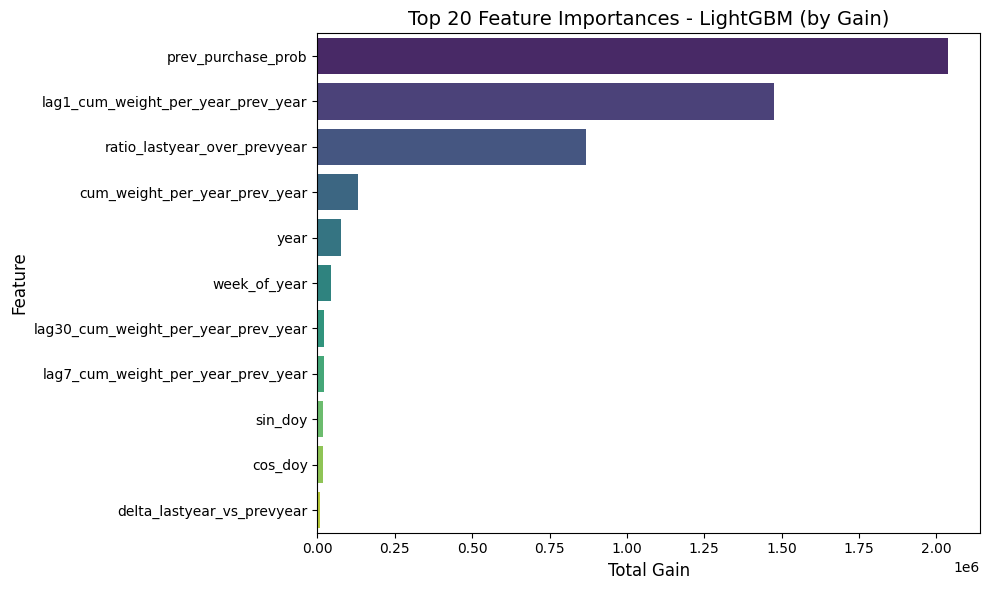

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ============================================================
# 🔍 Feature Importance for LightGBM Booster
# ============================================================

# Ensure this only runs if the model is a LightGBM Booster
if isinstance(lgb_model, lgb.Booster):
    print("📊 Displaying LightGBM Feature Importances...")

    # Extract feature importance and names
    importance_df = pd.DataFrame({
        'Feature': lgb_model.feature_name(),
        'Importance': lgb_model.feature_importance(importance_type='gain')  # 'gain' = total info gain
    })

    # Sort descending
    importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title("Top 20 Feature Importances - LightGBM (by Gain)", fontsize=14)
    plt.xlabel("Total Gain", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ The current model is not a LightGBM Booster — skipping feature importance plot.")

In [ ]:
# ============================================================
# 6. Model Interpretation (Feature Importance + PDP)
# ============================================================
#if hasattr(final_model, "feature_importances_"):
    #importances = pd.Series(final_model.feature_importances_, index=X.columns)
    #top_importances = importances.sort_values(ascending=False).head(20)

    #plt.figure(figsize=(10, 6))
    #sns.barplot(x=top_importances.values, y=top_importances.index)
    #plt.title(f"Top 20 Feature Importances - {best_model_name}")
    #plt.tight_layout()
    #plt.show()

    #top_features = top_importances.index[:3]
    #print(f"Plotting PDPs for: {list(top_features)}")
    #PartialDependenceDisplay.from_estimator(final_model, X, features=top_features)
    #plt.show()

## PREDICTIONS

In [431]:
import pandas as pd
import numpy as np

# ============================================================
# 🧠 0️⃣ Ensure trained model exists
# ============================================================
try:
    model = final_model
except NameError:
    if 'best_xgb' in globals():
        model = best_xgb
    #elif 'best_rf' in globals():
        #model = best_rf
    elif 'lgb_model' in globals():
        model = lgb_model
    else:
        raise NameError("❌ No trained model found. Run training first.")

pm_df = prediction_mapping.copy()

# --- Ensure date type ---
pm_df['forecast_end_date'] = pd.to_datetime(pm_df['forecast_end_date'], errors='coerce')

# --- Core calendar breakdown ---
pm_df['year'] = pm_df['forecast_end_date'].dt.year
pm_df['month'] = pm_df['forecast_end_date'].dt.month
pm_df['week_of_year'] = pm_df['forecast_end_date'].dt.isocalendar().week.astype(int)
pm_df['day_of_week'] = pm_df['forecast_end_date'].dt.dayofweek
pm_df['day_of_year'] = pm_df['forecast_end_date'].dt.dayofyear
pm_df['rm_id'] = pm_df['rm_id'].astype(str)

# ============================================================
# 🧭 Cyclical encodings for seasonality
# ============================================================
pm_df['sin_doy'] = np.sin(2 * np.pi * pm_df['day_of_year'] / 365)
pm_df['cos_doy'] = np.cos(2 * np.pi * pm_df['day_of_year'] / 365)

# ============================================================
# ✅ Summary check
# ============================================================
temporal_cols = ['year', 'week_of_year',
    'sin_doy', 'cos_doy'
]

print(f"✅ Prediction mapping (2025): {pm_df.shape}")
print(f"🧩 Added {len(temporal_cols) - 1} temporal features.")
display(pm_df[temporal_cols].head(10))

✅ Prediction mapping (2025): (30450, 11)
🧩 Added 3 temporal features.


,year,week_of_year,sin_doy,cos_doy
0,2025,1,0.034422,0.999407
1,2025,1,0.051620,0.998667
2,2025,1,0.068802,0.997630
3,2025,1,0.085965,0.996298
4,2025,2,0.103102,0.994671
5,2025,2,0.120208,0.992749
6,2025,2,0.137279,0.990532
7,2025,2,0.154309,0.988023
8,2025,2,0.171293,0.985220
9,2025,2,0.188227,0.982126


In [432]:
# ============================================================
# 2️⃣ Prepare base dataset (2023–2024 only)
# ============================================================
df_feat = df_rec_purchase[df_rec_purchase['year'].isin([2023, 2024])].copy()
df_feat['date_arrival'] = pd.to_datetime(df_feat['date_arrival'], errors='coerce')
df_feat['rm_id'] = df_feat['rm_id'].astype(str)
df_feat['week_of_year'] = df_feat['date_arrival'].dt.isocalendar().week.astype(int)
df_feat['day_of_week'] = df_feat['date_arrival'].dt.dayofweek
df_feat = df_feat.sort_values(['rm_id', 'year', 'week_of_year', 'day_of_week'])

print("✅ df_feat (2023–2024):", df_feat.shape)
df_feat.head()

✅ df_feat (2023–2024): (136800, 32)


,rm_id,date_arrival,year,day_of_year,month,net_weight,quantity,product_version,receival_item_no,product_id,...,lag7_cum_weight_per_year_prev_year,lag30_cum_weight_per_year_prev_year,prev_purchase_prob,days_with_purchase,total_days,delta_lastyear_vs_prevyear,ratio_lastyear_over_prevyear,quarter,sin_doy,cos_doy
231843,1842.0,2023-01-02,2023,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.0,0.0,NaN,1,0.034422,0.999407
231844,1842.0,2023-01-03,2023,3,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.0,0.0,NaN,1,0.051620,0.998667
231845,1842.0,2023-01-04,2023,4,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.0,0.0,NaN,1,0.068802,0.997630
231846,1842.0,2023-01-05,2023,5,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.0,0.0,NaN,1,0.085965,0.996298
231847,1842.0,2023-01-06,2023,6,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31.0,0.0,NaN,1,0.103102,0.994671


In [441]:
# ============================================================
# 3️⃣ Compute lag features (2024 only)
# ============================================================
df_2024 = df_feat[df_feat['year'] == 2024].copy()

# --- Drop any old duplicate columns before computing ---
df_2024 = df_2024.loc[:, ~df_2024.columns.duplicated()].copy()

# --- Compute lags grouped by rm_id ---
for lag in [1, 7, 30]:
    df_2024[f'lag{lag}_cum_weight_per_year_prev_year'] = (
        df_2024.groupby('rm_id')['cum_weight_per_year'].shift(lag)
    )

# --- Remove any existing cum_weight_per_year_prev_year before renaming ---
if 'cum_weight_per_year_prev_year' in df_2024.columns:
    df_2024 = df_2024.drop(columns=['cum_weight_per_year_prev_year'])

# --- Rename current year's cum_weight for clarity ---
df_2024 = df_2024.rename(columns={
    'cum_weight_per_year': 'cum_weight_per_year_prev_year'
})

# --- Keep only what we need for lag map ---
lag_map_2024 = (
    df_2024[[
        'rm_id',
        'week_of_year',
        'day_of_week',
        'cum_weight_per_year_prev_year',
        'lag1_cum_weight_per_year_prev_year',
        'lag7_cum_weight_per_year_prev_year',
        'lag30_cum_weight_per_year_prev_year'
    ]]
    .drop_duplicates()
    .reset_index(drop=True)
)

print(f"✅ lag_map_2024 created successfully: {lag_map_2024.shape}")
print(lag_map_2024.head(10))


✅ lag_map_2024 created successfully: (67260, 7)
    rm_id  week_of_year  day_of_week  cum_weight_per_year_prev_year  \
0  1842.0             1            0                            0.0   
1  1842.0             1            1                            0.0   
2  1842.0             1            2                            0.0   
3  1842.0             1            3                            0.0   
4  1842.0             1            4                            0.0   
5  1842.0             1            5                            0.0   
6  1842.0             1            6                            0.0   
7  1842.0             2            0                            0.0   
8  1842.0             2            1                            0.0   
9  1842.0             2            2                            0.0   

   lag1_cum_weight_per_year_prev_year  lag7_cum_weight_per_year_prev_year  \
0                                 NaN                                 NaN   
1               

In [442]:
# ============================================================
# 4️⃣ 2-year averages (2023 + 2024)
# ============================================================
avg_features_df = (
    df_feat.groupby(['rm_id', 'week_of_year', 'day_of_week'], as_index=False)
    .agg({
        'quantity': 'mean',
        'net_weight': 'mean',
        'receival_item_no': 'mean',
        'supplier_id': 'mean',
    })
)
avg_features_df = avg_features_df.rename(columns={
    'quantity': 'avg_quantity',
    'net_weight': 'avg_net_weight',
    'receival_item_no': 'avg_receival_item_no',
    'supplier_id': 'avg_supplier_id',
})

print("✅ avg_features_df:", avg_features_df.shape)
avg_features_df.head()


✅ avg_features_df: (69160, 7)


,rm_id,week_of_year,day_of_week,avg_quantity,avg_net_weight,avg_receival_item_no,avg_supplier_id
0,1842.0,1,0,0.0,0.0,0.0,0.0
1,1842.0,1,1,0.0,0.0,0.0,0.0
2,1842.0,1,2,0.0,0.0,0.0,0.0
3,1842.0,1,3,0.0,0.0,0.0,0.0
4,1842.0,1,4,0.0,0.0,0.0,0.0


In [443]:
# ============================================================
# 5️⃣ Previous purchase probability (Oct–Dec 2024)
# ============================================================
df_prob = df_rec_purchase.copy()
df_prob['date_arrival'] = pd.to_datetime(df_prob['date_arrival'], errors='coerce')
df_prob['year'] = df_prob['date_arrival'].dt.year
df_prob['month'] = df_prob['date_arrival'].dt.month
df_prob['rm_id'] = df_prob['rm_id'].astype(str)
df_prob['purchase_flag'] = (df_prob['net_weight'] > 0).astype(int)

df_prob_oct_dec = df_prob[(df_prob['year'] == 2024) & (df_prob['month'].isin([10, 11, 12]))]
purchase_prob_df = (
    df_prob_oct_dec.groupby('rm_id', as_index=False)
    .agg(
        days_with_purchase=('purchase_flag', 'sum'),
        total_days=('date_arrival', 'nunique')
    )
)
purchase_prob_df['prev_purchase_prob'] = (
    purchase_prob_df['days_with_purchase'] / purchase_prob_df['total_days']
)

print("✅ purchase_prob_df:", purchase_prob_df.shape)
purchase_prob_df.head()

✅ purchase_prob_df: (190, 4)


,rm_id,days_with_purchase,total_days,prev_purchase_prob
0,1842.0,0,80,0.0
1,1843.0,0,80,0.0
2,1844.0,0,80,0.0
3,1845.0,0,80,0.0
4,1846.0,0,80,0.0


In [445]:
# ============================================================
# 6️⃣ Combine all feature sets (2023–2024)
# ============================================================

# --- 1️⃣ Standardize key dtypes across all DataFrames ---
for df in [avg_features_df, lag_map_2024]:
    df['rm_id'] = (
        df['rm_id']
        .astype(str)
        .str.replace('.0', '', regex=False)
        .str.strip()
    )
    df['week_of_year'] = df['week_of_year'].astype(int)
    df['day_of_week'] = df['day_of_week'].astype(int)

purchase_prob_df['rm_id'] = (
    purchase_prob_df['rm_id']
    .astype(str)
    .str.replace('.0', '', regex=False)
    .str.strip()
)

# --- 2️⃣ Restrict avg_features_df to keys that exist in lag_map_2024 ---
valid_keys = lag_map_2024[['rm_id', 'week_of_year', 'day_of_week']].drop_duplicates()
avg_features_df = avg_features_df.merge(
    valid_keys,
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='inner'
)

print(f"✅ Key alignment check:")
print(f"   avg_features_df: {len(avg_features_df):,} rows")
print(f"   lag_map_2024: {len(lag_map_2024):,} rows")

# --- 3️⃣ Merge avg + lag features (same keys) ---
features_df = avg_features_df.merge(
    lag_map_2024,
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='left'
)

# --- 4️⃣ Add prev_purchase_prob (by rm_id only) ---
features_df = features_df.merge(
    purchase_prob_df[['rm_id', 'prev_purchase_prob']],
    on='rm_id',
    how='left'
)

# --- 5️⃣ Compute delta and ratio directly inside features_df ---
required_cols = ['lag7_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year']
missing = [c for c in required_cols if c not in features_df.columns]
if missing:
    raise KeyError(f"Missing required columns in features_df: {missing}")

# Compute delta (difference between 7-day lag and actual previous-year cumulative)
features_df['delta_lastyear_vs_prevyear'] = (
    features_df['lag7_cum_weight_per_year_prev_year'] -
    features_df['cum_weight_per_year_prev_year']
)

# Compute ratio (relative deviation)
features_df['ratio_lastyear_over_prevyear'] = np.where(
    features_df['cum_weight_per_year_prev_year'] != 0,
    features_df['lag7_cum_weight_per_year_prev_year'] / features_df['cum_weight_per_year_prev_year'],
    np.nan
)

# --- 6️⃣ Final consistency checks ---
missing_lags = features_df['lag7_cum_weight_per_year_prev_year'].isna().sum()
print(f"✅ features_df (combined): {features_df.shape}")
print(f"✅ Missing lag7 values after merge: {missing_lags:,}")
print(f"✅ Added delta_lastyear_vs_prevyear and ratio_lastyear_over_prevyear")


# Preview
print(features_df[
    ['rm_id', 'week_of_year', 'day_of_week',
     'lag1_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year',
     'lag7_cum_weight_per_year_prev_year','lag30_cum_weight_per_year_prev_year',
     'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear']
].head(10))

✅ Key alignment check:
   avg_features_df: 67,260 rows
   lag_map_2024: 67,260 rows
✅ features_df (combined): (67260, 14)
✅ Missing lag7 values after merge: 1,330
✅ Added delta_lastyear_vs_prevyear and ratio_lastyear_over_prevyear
  rm_id  week_of_year  day_of_week  lag1_cum_weight_per_year_prev_year  \
0  1842             1            0                                 NaN   
1  1842             1            1                                 0.0   
2  1842             1            2                                 0.0   
3  1842             1            3                                 0.0   
4  1842             1            4                                 0.0   
5  1842             1            5                                 0.0   
6  1842             1            6                                 0.0   
7  1842             2            0                                 0.0   
8  1842             2            1                                 0.0   
9  1842             2        

In [447]:
# ============================================================
# 7️⃣ Merge computed features into 2025 prediction mapping
# ============================================================

# Ensure keys have consistent dtypes
for df in [pm_df, features_df]:
    df['rm_id'] = (
        df['rm_id']
        .astype(str)
        .str.replace('.0', '', regex=False)
        .str.strip()
    )
    df['week_of_year'] = df['week_of_year'].astype(int)
    df['day_of_week'] = df['day_of_week'].astype(int)

# Merge by rm_id + week_of_year + day_of_week (no forward fill)
pred_df = pm_df.merge(
    features_df,
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='left'
)

# Fill missing numeric feature values with zero
num_cols = pred_df.select_dtypes(include=[np.number]).columns
#pred_df[num_cols] = pred_df[num_cols].fillna(0)

print(f"✅ pred_df after merging and filling: {pred_df.shape}")
print(f"   Remaining NaN values (should be 0): {pred_df.isna().sum().sum()}")

# Quick check of sample rows
pred_df.head(10)

✅ pred_df after merging and filling: (30450, 22)
   Remaining NaN values (should be 0): 51077


,ID,rm_id,forecast_start_date,forecast_end_date,year,month,week_of_year,day_of_week,day_of_year,sin_doy,...,avg_net_weight,avg_receival_item_no,avg_supplier_id,cum_weight_per_year_prev_year,lag1_cum_weight_per_year_prev_year,lag7_cum_weight_per_year_prev_year,lag30_cum_weight_per_year_prev_year,prev_purchase_prob,delta_lastyear_vs_prevyear,ratio_lastyear_over_prevyear
0,1,365,2025-01-01,2025-01-02,2025,1,1,3,2,0.034422,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
1,2,365,2025-01-01,2025-01-03,2025,1,1,4,3,0.051620,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
2,3,365,2025-01-01,2025-01-04,2025,1,1,5,4,0.068802,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
3,4,365,2025-01-01,2025-01-05,2025,1,1,6,5,0.085965,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
4,5,365,2025-01-01,2025-01-06,2025,1,2,0,6,0.103102,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
5,6,365,2025-01-01,2025-01-07,2025,1,2,1,7,0.120208,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
6,7,365,2025-01-01,2025-01-08,2025,1,2,2,8,0.137279,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
7,8,365,2025-01-01,2025-01-09,2025,1,2,3,9,0.154309,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
8,9,365,2025-01-01,2025-01-10,2025,1,2,4,10,0.171293,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
9,10,365,2025-01-01,2025-01-11,2025,1,2,5,11,0.188227,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN


In [448]:
# ============================================================
# 8️⃣ Align features for model
# ============================================================
if hasattr(model, "feature_name"):
    model_features = list(model.feature_name())
elif hasattr(model, "feature_names_in_"):
    model_features = list(model.feature_names_in_)
elif hasattr(model, "get_booster"):
    model_features = list(model.get_booster().feature_names)
else:
    model_features = list(X_train.columns)

for f in model_features:
    if f not in pred_df.columns:
        pred_df[f] = np.nan

X_pred = pred_df[model_features].apply(pd.to_numeric, errors='coerce')

print("✅ Model features found:", len(model_features))
print("Missing values per feature:\n", X_pred.isna().sum())


✅ Model features found: 11
Missing values per feature:
 year                                       0
week_of_year                               0
sin_doy                                    0
cos_doy                                    0
lag1_cum_weight_per_year_prev_year      1950
delta_lastyear_vs_prevyear              2710
ratio_lastyear_over_prevyear           24927
prev_purchase_prob                      1950
lag7_cum_weight_per_year_prev_year      2710
lag30_cum_weight_per_year_prev_year     7080
cum_weight_per_year_prev_year           1950
dtype: int64


In [449]:
# ============================================================
# 9️⃣ Predict cum_weight_year directly
# ============================================================
pred_df['predicted_weight'] = np.maximum(0, model.predict(X_pred))

# ============================================================
# 🔟 Mask week 1 of 2025
# ============================================================
mask_week1_2025 = (pred_df['year'] == 2025) & (pred_df['week_of_year'] == 1)
pred_df.loc[mask_week1_2025, 'predicted_weight'] = 0

# ============================================================
# 🏁 Save Final Submission
# ============================================================
submission = pred_df[['ID', 'predicted_weight']].drop_duplicates(subset=['ID']).sort_values(by='ID')
submission.to_csv("submission_2025_predictions_cumweightyear.csv", index=False)

print("✅ Final 2025 predictions ready!")
print("Submission shape:", submission.shape)
submission.head()

✅ Final 2025 predictions ready!
Submission shape: (30450, 2)


,ID,predicted_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [ ]:
#import pandas as pd
#import numpy as np

# ============================================================
# Ensure trained model exists
# ============================================================
#try:
    #model = final_model
#except NameError:
    #if 'best_xgb' in globals():
        #model = best_xgb
    #elif 'best_rf' in globals():
        #model = best_rf
    #else:
        #raise NameError("No trained model found. Run training first.")

# ============================================================
# 1️⃣ Prepare prediction mapping
# ============================================================
#pm_df = prediction_mapping.copy()
#pm_df['forecast_end_date'] = pd.to_datetime(pm_df['forecast_end_date'], errors='coerce')
#pm_df['month'] = pm_df['forecast_end_date'].dt.month
#pm_df['day_of_week'] = pm_df['forecast_end_date'].dt.weekday  # Monday=0
#pm_df['week_of_year'] = pm_df['forecast_end_date'].dt.isocalendar().week.astype(int)
#pm_df['year'] = pm_df['forecast_end_date'].dt.year

# ============================================================
# 2️⃣ Compute 2-year rolling features from 2023–2024
# ============================================================
#rolling_features = ['net_weight', 'quantity', 'supplier_id']
#df_rolling = df_rec_purchase[df_rec_purchase['year'].isin([2023, 2024])].copy()

#roll2yr_df = (
    #df_rolling
    #.groupby(['rm_id', 'week_of_year', 'day_of_week'])[rolling_features]
    #.mean()
    #.reset_index()
#)
#roll2yr_df = roll2yr_df.rename(columns={c: f'roll2yr_{c}' for c in rolling_features})

# ============================================================
# 3️⃣ Extract avg features and purchase_prob
# ============================================================
#avg_features = [c for c in df_rec_purchase.columns if c.startswith('avg_')]
#purchase_prob_df = df_rec_purchase[['rm_id', 'purchase_prob']].drop_duplicates(subset=['rm_id'])

#rm_features_df = df_rec_purchase[['rm_id', 'week_of_year', 'day_of_week'] + avg_features].drop_duplicates()
#rm_features_df = rm_features_df.merge(purchase_prob_df, on='rm_id', how='left')
#rm_features_df = rm_features_df.merge(roll2yr_df, on=['rm_id', 'week_of_year', 'day_of_week'], how='left')

# ============================================================
# 4️⃣ Keep only combinations that existed in 2024
# ============================================================
#valid_2024 = df_rec_purchase.loc[
    #df_rec_purchase['year'] == 2024,
    #['rm_id', 'week_of_year', 'day_of_week']
#].drop_duplicates()
#rm_features_df = rm_features_df.merge(valid_2024, on=['rm_id', 'week_of_year', 'day_of_week'], how='inner')

# ============================================================
# 5️⃣ Merge features into prediction mapping
# ============================================================
#pred_df = pm_df.merge(rm_features_df, on=['rm_id', 'week_of_year', 'day_of_week'], how='left')

# ============================================================
# 6️⃣ Align feature order exactly as in training
# ============================================================
#required_features = model.feature_names_in_
#for c in required_features:
    #if c not in pred_df.columns:
        #pred_df[c] = 0
#X_pred = pred_df[required_features].fillna(0)

# ============================================================
# 7️⃣ Predict Net Weight
# ============================================================
#pred_df['predicted_net_weight'] = model.predict(X_pred)
#pred_df['predicted_net_weight'] = np.maximum(0, pred_df['predicted_net_weight'])

# ============================================================
# 8️⃣ Random selection of active weekdays per RM_ID/month
# ============================================================
# Compute active weekdays in 2024 per RM_ID/month
#active_2024 = (
    #df_rec_purchase.loc[
        #(df_rec_purchase['year'] == 2024) &
        #(df_rec_purchase['day_of_week'] < 5)
    #]
    #.assign(month=lambda df: df['date_arrival'].dt.month)
    #.groupby(['rm_id', 'month'])['day_of_week']
    #.nunique()
    #.reset_index(name='active_days_2024')
#)

# Determine target number of days to predict (e.g., 60% of active days)
#active_2024['target_days_2025'] = np.ceil(active_2024['active_days_2024'] * 0.9)

# Initialize flag
#pred_df['predict_flag'] = False

# Apply random selection per RM_ID/month
#for (rm, month), group in pred_df.groupby(['rm_id', 'month']):
    #weekday_idx = group.index[group['day_of_week'] < 5].to_numpy()
    
    # Skip if no weekdays
    #if len(weekday_idx) == 0:
        #continue
    
    #target_n = active_2024.loc[
        #(active_2024['rm_id'] == rm) & (active_2024['month'] == month),
        #'target_days_2025'
    #].values
    #if len(target_n) == 0:
        #continue
    #target_n = int(target_n[0])  # cast to integer
    
    #if len(weekday_idx) <= target_n:
        #chosen_idx = weekday_idx
    #else:
        #chosen_idx = np.random.choice(weekday_idx, size=target_n, replace=False)
    
    #pred_df.loc[chosen_idx, 'predict_flag'] = True

# ============================================================
# 9️⃣ Force zeros for invalid predictions
# ============================================================
#before_week2_mask = pred_df['week_of_year'] < 2
#unseen_mask = ~pred_df['rm_id'].isin(df_rec_purchase['rm_id'])
#weekend_mask = pred_df['day_of_week'] >= 5
#not_chosen_mask = ~pred_df['predict_flag']
#invalid_combo_mask = ~pred_df.set_index(['rm_id', 'week_of_year', 'day_of_week']).index.isin(
    #valid_2024.set_index(['rm_id', 'week_of_year', 'day_of_week']).index
#)

#pred_df.loc[
    #before_week2_mask | unseen_mask | weekend_mask | invalid_combo_mask | not_chosen_mask,
    #'predicted_net_weight'
#] = 0

# ============================================================
# 🔟 Compute cumulative sum per RM_ID
# ============================================================
#pred_df = pred_df.sort_values(['rm_id', 'week_of_year', 'day_of_week'])
#pred_df['predicted_weight'] = pred_df.groupby('rm_id')['predicted_net_weight'].cumsum()

# ============================================================
# 1️⃣1️⃣ Build Final Submission
# ============================================================
#submission = pred_df[['ID', 'predicted_weight']].copy().sort_values(by='ID')
#submission.to_csv("submission_2025_predictions_cumsum_random_weekdays.csv", index=False)

#print("✅ Cumulative predictions for 2025 with random weekdays ready!")
#print(submission.head())